# Tugas Akhir - "Deteksi Logo Kendaraan Menggunakan Metode Detection Transformers"
[![Huggingface](https://camo.githubusercontent.com/b0242aba08cbaf9670cb3f59bb946606c709c80409bf20141a01ded0f889d0b0/68747470733a2f2f68756767696e67666163652e636f2f64617461736574732f68756767696e67666163652f646f63756d656e746174696f6e2d696d616765732f7261772f6d61696e2f7472616e73666f726d6572732d6c6f676f2d6461726b2e737667)](https://huggingface.co/facebook/detr-resnet-50)

[![Python](https://badges.aleen42.com/src/python.svg)](https://www.python.org/)

Diajukan untuk memenuhi salah satu syarat memperoleh gelar sarjana 
dari Program Studi S1 Informatika
Fakultas Informatika
Universitas Telkom

Nama : Rifky Fahrizal Ubaidillah
NIM : 1301204054

## Konten
Notebook ini merupakan salah satu dari beberapa eksperimen pada training model DETR. Konfigurasi yang dilakukan berfokus pada perubahan nilai *Gradient CLip Validation* dan *Accumulate Gradient Batches*. Pengujian ini meliputi beberapa tahapan yaitu:
- Import library
- Training model
- Inferensi citra
- Evaluasi model

Referensi:
| Judul | Link |
| ------ | ------ |
| Meta Research - DE⫶TR: End-to-End Object Detection with Transformers | [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/facebookresearch/detr) |
| Roboflow - How to Train DETR with 🤗 Transformers on a Custom Dataset | [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks/blob/main/notebooks/train-huggingface-detr-on-custom-dataset.ipynb) |
| NielsRogge - Fine-tuning DETR on a custom dataset for object detection | [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DETR/Fine_tuning_DetrForObjectDetection_on_custom_dataset_(balloon).ipynb) |
| Adham Mohamed - Object-Detection-Interpretation-for-Advanced-Models | [![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/adhammohamed1/Object-Detection-Interpretation-for-Advanced-Models/blob/main/detr.ipynb) |

Sumber Tambahan :
| Judul | Link |
| ------ | ------ |
| Umar Farooq - Vehicle Logos (VL)-10  | https://www.kaggle.com/datasets/mufarooqq/vl-10/data |
| Alberto1404 - Prepare dataset from YOLO format to COCO for DETR | https://discuss.huggingface.co/t/prepare-dataset-from-yolo-format-to-coco-for-detr/34894/2 |


## Setup environment

In [1]:
# !python -m pip install --upgrade pip
# !pip install supervision==0.3.0
# !pip install transformers
# !pip install pytorch-lightning
# !pip install cython
# !pip install pycocotools
# !pip install scipy
# !pip install -q coco_eval
# !pip install tensorboard

In [1]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

import supervision
import transformers
import pytorch_lightning

print(
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; pytorch_lightning:", pytorch_lightning.__version__
)

nvcc: NVIDIA (R) Cuda compiler drivertorch:  2.2 ; cuda:  cu121

Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:09:35_Pacific_Daylight_Time_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
; supervision: 0.3.0 ; transformers: 4.37.2 ; pytorch_lightning: 2.1.4


## Create dataloaders

In [2]:
import os
import torchvision

# Dataset sudah melalui tahapan konversi sebelumnya YOLO menjadi COCO

ANNOTATION_FILE_NAME = "annotations.coco.json"
TRAIN_DIRECTORY = 'VL-10/images/train/'
VAL_DIRECTORY = 'VL-10/images/val/'

from transformers import DetrImageProcessor

image_processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self, 
        image_directory_path: str, 
        image_processor, 
        train: bool = True
    ):
        annotation_file_path = os.path.join(image_directory_path, ANNOTATION_FILE_NAME)
        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)
        self.image_processor = image_processor

    def __getitem__(self, idx):
        images, annotations = super(CocoDetection, self).__getitem__(idx)        
        image_id = self.ids[idx]
        annotations = {'image_id': image_id, 'annotations': annotations}
        encoding = self.image_processor(images=images, annotations=annotations, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze()
        target = encoding["labels"][0]

        return pixel_values, target


TRAIN_DATASET = CocoDetection(image_directory_path=TRAIN_DIRECTORY, image_processor=image_processor, train=True)
VAL_DATASET = CocoDetection(image_directory_path=VAL_DIRECTORY, image_processor=image_processor, train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))

loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of training examples: 14995
Number of validation examples: 1500


Image #4236


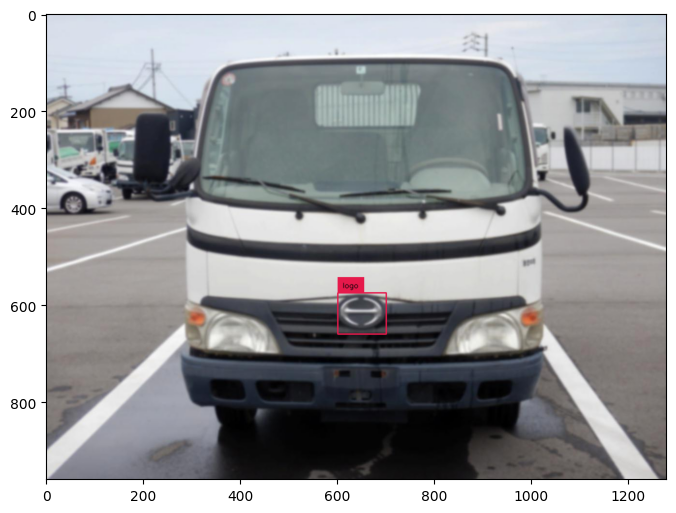

In [3]:
# Melakukan visualisasi pada citra yang telah di anotasi

import random
import cv2
import numpy as np
import supervision as sv

image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

categories = TRAIN_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}

labels = [
    f"{id2label[class_id]}" 
    for _, _, class_id, _ 
    in detections
]

box_annotator = sv.BoxAnnotator()
frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)

%matplotlib inline  
sv.show_frame_in_notebook(image, (8, 8))

In [3]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = image_processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    return {
        'pixel_values': encoding['pixel_values'],
        'pixel_mask': encoding['pixel_mask'],
        'labels': labels
    }

TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)

## Train model 

Tahap ini melakukan training model pada custom dataset menggunakan PyTorch Lightning

In [4]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection
import torch


class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                            num_labels=len(id2label),
                                                            ignore_mismatched_sizes=True)
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        return self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        # logs metrics for each training_step, and the average across the epoch
        self.log("training_loss", loss)
        for k,v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)     
        self.log("validation/loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())
            
        return loss

    def configure_optimizers(self):
        # DETR authors decided to use different learning rate for backbone
        # you can learn more about it here: 
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L22-L23
        # - https://github.com/facebookresearch/detr/blob/3af9fa878e73b6894ce3596450a8d9b89d918ca9/main.py#L131-L139
        param_dicts = [
            {
                "params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        return torch.optim.AdamW(param_dicts, lr=self.lr, weight_decay=self.weight_decay)

    def train_dataloader(self):
        return TRAIN_DATALOADER

    def val_dataloader(self):
        return VAL_DATALOADER

In [7]:
# Dapat melihat log menggunakan Tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/
#tensorboard --logdir .

Launching TensorBoard...

In [6]:
model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

batch = next(iter(TRAIN_DATALOADER))
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=batch['pixel_mask'])

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

In [9]:
# This is a tensor of shape (batch_size, num_queries, d_model)
outputs.logits.shape

torch.Size([4, 100, 2])

In [10]:
from pytorch_lightning import Trainer

MAX_EPOCHS = 25

# Tahap ini, penulis melakukan konfigurasi parameter yang akan diuji
trainer = Trainer(devices=1, accelerator="gpu", max_epochs=MAX_EPOCHS, log_every_n_steps=5, gradient_clip_val=0.5, accumulate_grad_batches=4)

trainer.fit(model, ckpt_path='lightning_logs/version_33/checkpoints/epoch=14-step=14070.ckpt/')
#trainer.fit(model)

# Save model secara lokal
MODEL_PATH = 'custom-model-task-1.7.1'
model.model.save_pretrained(MODEL_PATH)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Restoring states from the checkpoint path at lightning_logs/version_35/checkpoints/epoch=15-step=7504.ckpt/
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\migration\utils.py:55: The loaded checkpoint was produced with Lightning v2.2.2, which is newer than your current Lightning version: v2.1.4
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:3

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 4. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


# Save and load model

In [11]:
# Save model secara online menggunakan Huggingface

from huggingface_hub import notebook_login
notebook_login()

In [12]:
# Upload model ke Huggingface

model.model.push_to_hub("rifzzu/detr_vehicle_logo_4")
image_processor.push_to_hub("rifzzu/detr_vehicle_logo_4")

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lenovo\.cache\huggingface\hub\models--rifzzu--detr_vehicle_logo_4. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.18k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/rifzzu/detr_vehicle_logo_4/commit/65221e87a636180b1d502431144df9882652321d', commit_message='Upload processor', commit_description='', oid='65221e87a636180b1d502431144df9882652321d', pr_url=None, pr_revision=None, pr_num=None)

In [14]:
# Load model dari Huggingface

from transformers import DetrImageProcessor, DetrForObjectDetection
import torch

model = DetrForObjectDetection.from_pretrained("rifzzu/detr_vehicle_logo_4", id2label={0:"logo"})
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
image_processor = DetrImageProcessor.from_pretrained("rifzzu/detr_vehicle_logo_4")

config.json:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/166M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

In [5]:
# Load model yang disimpan lokal
MODEL_PATH = 'custom-model-task-1.7.1'

model = DetrForObjectDetection.from_pretrained(MODEL_PATH)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

## Inference on dataset

Setelah melakukan training, langkah selanjutnya yaitu inferensi pada dataset. 

Image #1178


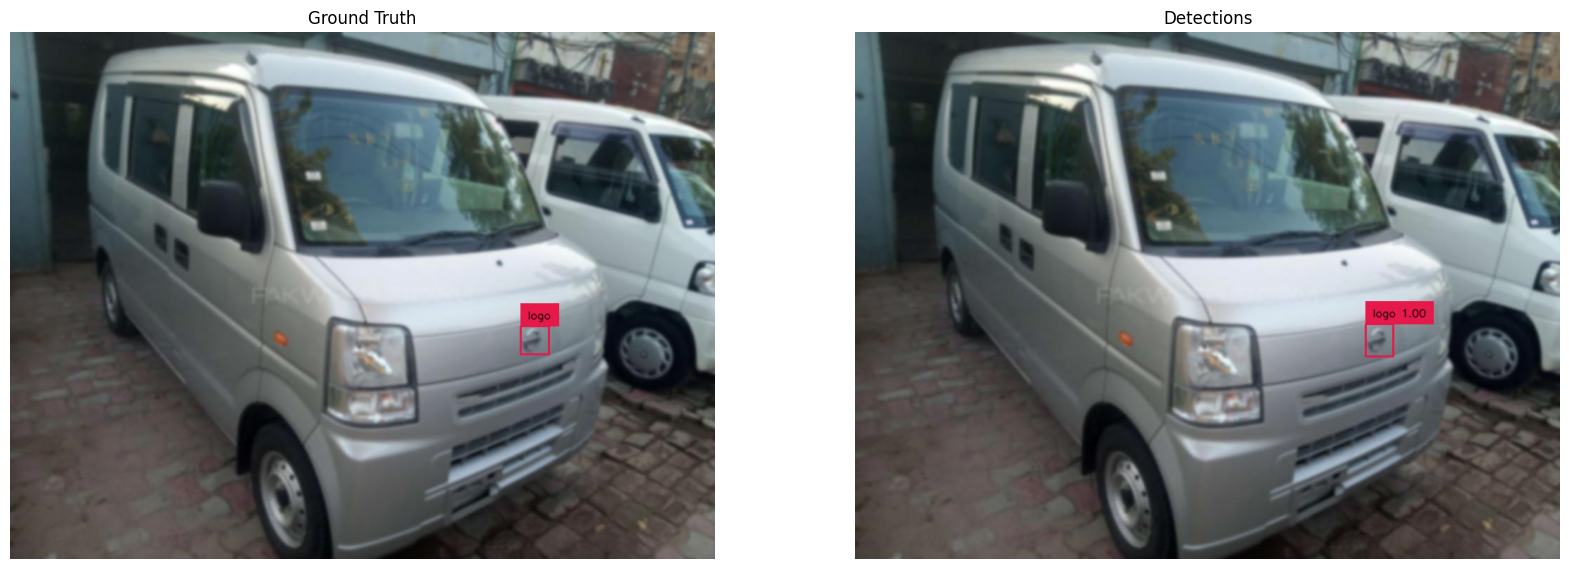

In [8]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt


# utils
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = VAL_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons 
image = VAL_DATASET.coco.loadImgs(image_id)[0]
annotations = VAL_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(VAL_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Annotate detections
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.9, 
        target_sizes=target_sizes
    )[0]


    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)


# %matplotlib inline # Remove this line, we won't use it anymore

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()


Image #467
Prediction #0: logo | Confidence: 0.999


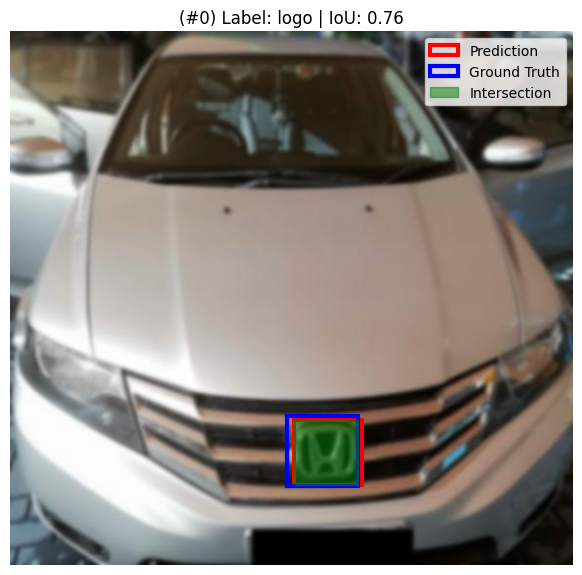


Average IoU: 0.7622724850694685


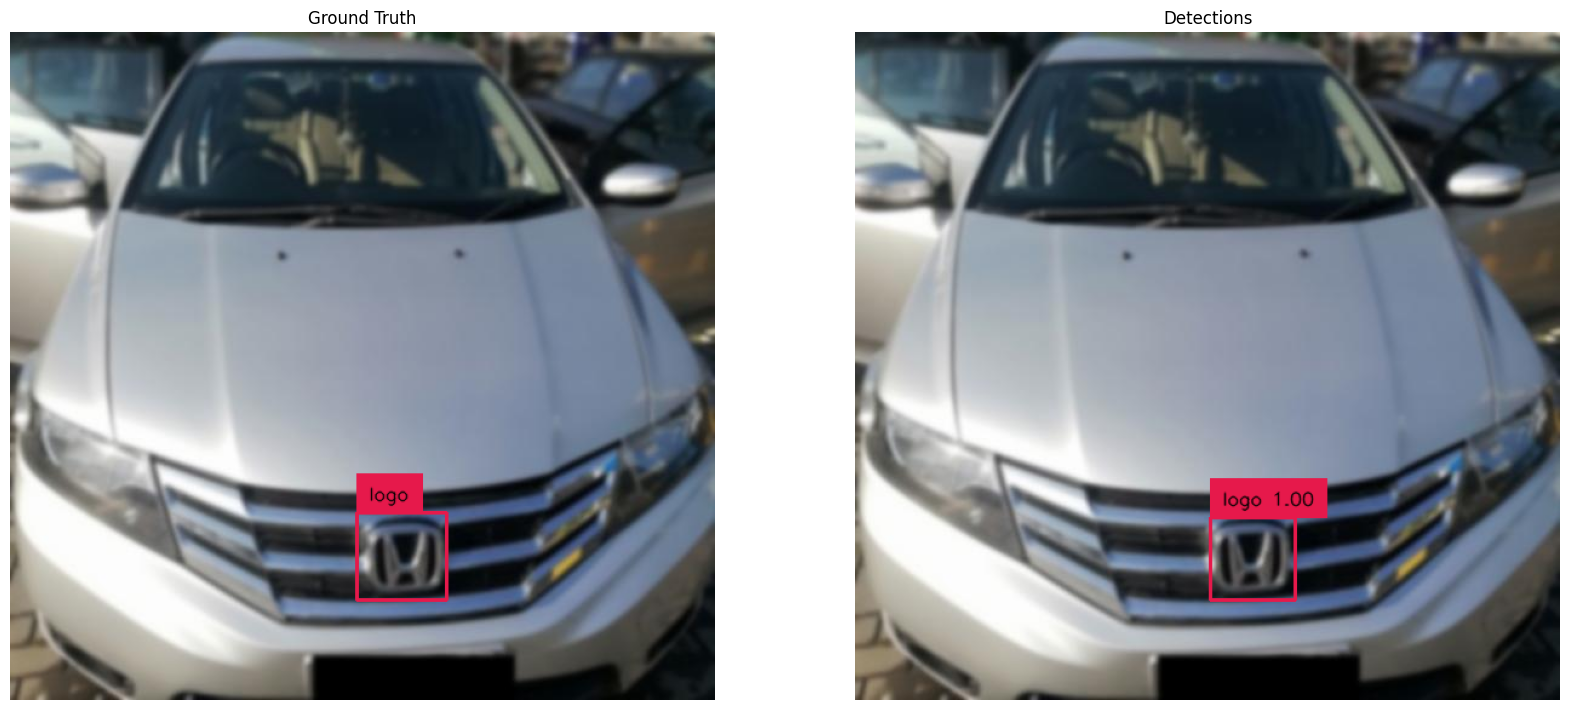

In [17]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
import supervision as sv

def get_intersection(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    return (x1, y1, x2, y2), intersection

def compute_iou(box1, box2):
    _, intersection_area = get_intersection(box1, box2)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - intersection_area
    iou = intersection_area / union_area
    return iou

# utils
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = VAL_DATASET.coco.getImgIds()
#image_id = random.choice(image_ids)
image_id = 467
print('Image #{}'.format(image_id))

# load image and annotations
image = VAL_DATASET.coco.loadImgs(image_id)[0]
annotations = VAL_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(VAL_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Annotate detections
with torch.no_grad():
    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)
    
    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.9, 
        target_sizes=target_sizes
    )[0]

    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    total_iou = 0
    for idx, bbox in enumerate(results['boxes'].tolist()):
        print(f'Prediction #{idx}: {id2label[results["labels"][idx].item()]} | Confidence: {results["scores"][idx]:.3f}')
        plt.figure(figsize=(9,9))
        num_rows = (len(annotations) + 1) // 2
        
        max_iou = 0
        for ann_idx, gt in enumerate(annotations):
            gt_bbox = gt['bbox'].copy()
            gt_bbox[2] = gt_bbox[0] + gt_bbox[2]
            gt_bbox[3] = gt_bbox[1] + gt_bbox[3]
            iou = compute_iou(bbox, gt_bbox)
            if iou > max_iou and results['labels'][idx] == gt['category_id']:
                max_iou = iou

            plt.subplot(num_rows, 2, ann_idx + 1)
            plt.title(f'(#{ann_idx}) Label: {id2label[gt["category_id"]]} | IoU: {iou:.2f}')
            plt.imshow(image)
            ax = plt.gca()
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, color='r', linewidth=3, label='Prediction'))
            ax.add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2] - gt_bbox[0], gt_bbox[3] - gt_bbox[1], fill=False, color='b', linewidth=3, label='Ground Truth'))
            intersection = get_intersection(bbox, gt_bbox)[0]
            ax.add_patch(plt.Rectangle((intersection[0], intersection[1]), max(0, intersection[2] - intersection[0]), max(0, intersection[3] - intersection[1]),
                                    fill=True, color='g', linewidth=1, alpha=0.5, label='Intersection'))
            plt.axis('off')
            plt.legend()
            plt.subplots_adjust(right=1.5)
        plt.show()
        total_iou += max_iou
    print()
    print("Average IoU:", total_iou / len(results['boxes']))

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()

Image #735
Prediction #0: logo | Confidence: 0.999


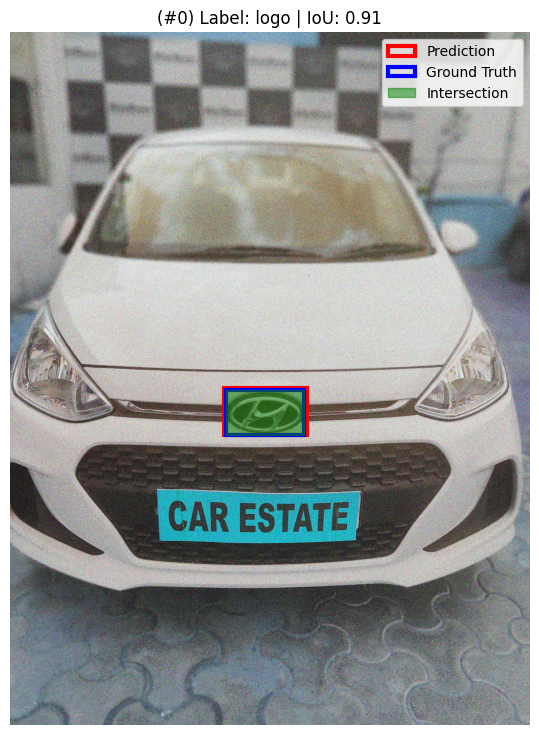


Average IoU: 0.9059546486353285


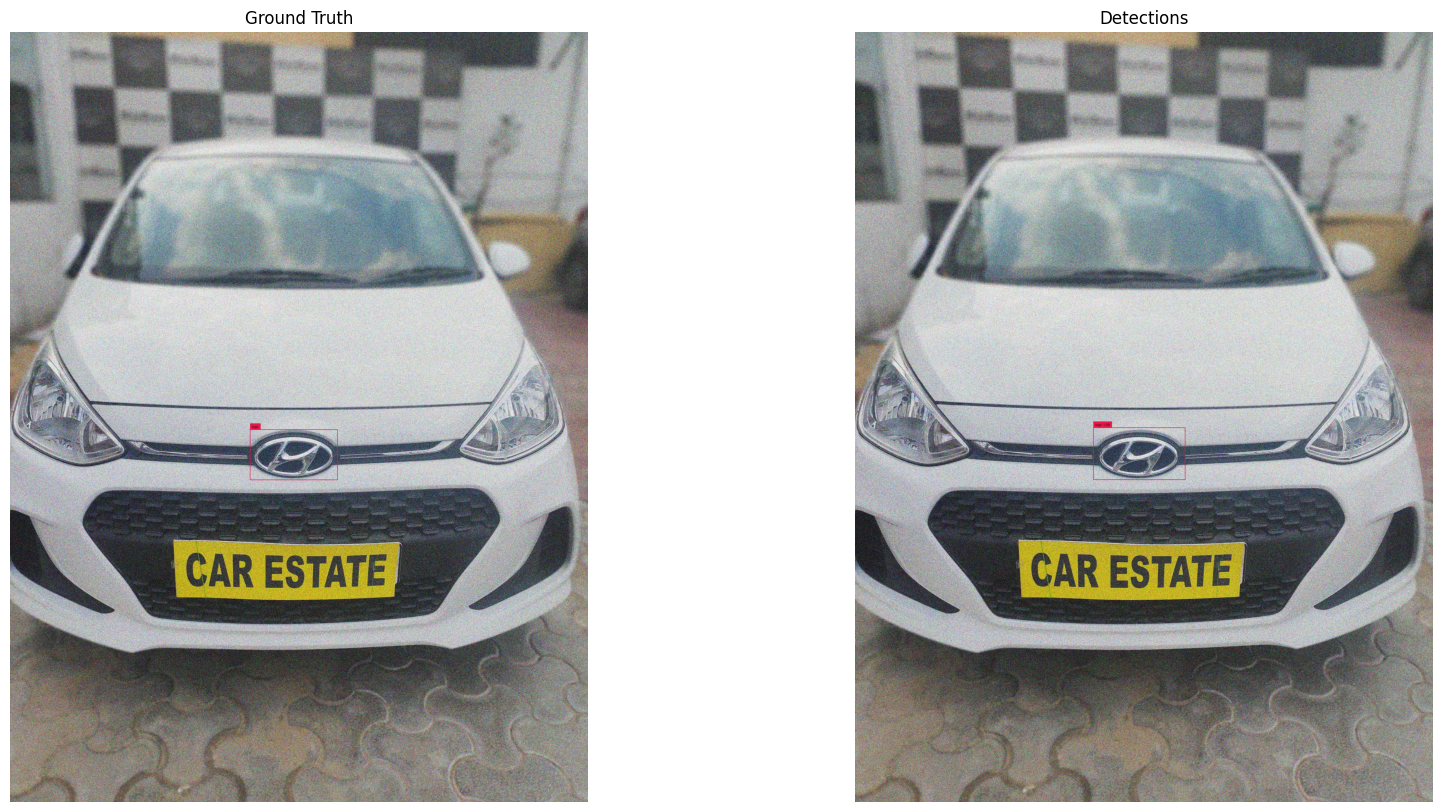

In [28]:
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

def get_intersection(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    return (x1, y1, x2, y2), intersection

def compute_iou(box1, box2):
    _, intersection_area = get_intersection(box1, box2)
    
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area

    return iou

# utils
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = VAL_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
#image_id = 1358
print('Image #{}'.format(image_id))

# load image and annotations
image = VAL_DATASET.coco.loadImgs(image_id)[0]
annotations = VAL_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(VAL_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Annotate detections
with torch.no_grad():
    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)
    
    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.9, 
        target_sizes=target_sizes
    )[0]

    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    total_iou = 0
    for idx, bbox in enumerate(results['boxes'].tolist()):
        print(f'Prediction #{idx}: {id2label[results["labels"][idx].item()]} | Confidence: {results["scores"][idx]:.3f}')
        plt.figure(figsize=(9,9))
        num_rows = (len(annotations) + 1) // 2
        
        max_iou = 0
        for ann_idx, gt in enumerate(annotations):
            gt_bbox = gt['bbox'].copy()
            gt_bbox[2] = gt_bbox[0] + gt_bbox[2]
            gt_bbox[3] = gt_bbox[1] + gt_bbox[3]

            iou = compute_iou(bbox, gt_bbox)
            if iou > max_iou and results['labels'][idx] == gt['category_id']:
                max_iou = iou

            plt.subplot(num_rows, 2, ann_idx + 1)
            plt.title(f'(#{ann_idx}) Label: {id2label[gt["category_id"]]} | IoU: {iou:.2f}')
            plt.imshow(image)
            ax = plt.gca()
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, color='r', linewidth=3, label='Prediction'))
            ax.add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2] - gt_bbox[0], gt_bbox[3] - gt_bbox[1], fill=False, color='b', linewidth=3, label='Ground Truth'))
            intersection = get_intersection(bbox, gt_bbox)[0]
            ax.add_patch(plt.Rectangle((intersection[0], intersection[1]), max(0, intersection[2] - intersection[0]), max(0, intersection[3] - intersection[1]),
                                    fill=True, color='g', linewidth=1, alpha=0.5, label='Intersection'))
            plt.axis('off')
            plt.legend()

            plt.subplots_adjust(right=1.5)

        plt.show()

        total_iou += max_iou

    print()
    print("Average IoU:", total_iou / len(results['boxes']))

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()

Image #960
Prediction #0: logo | Confidence: 0.989


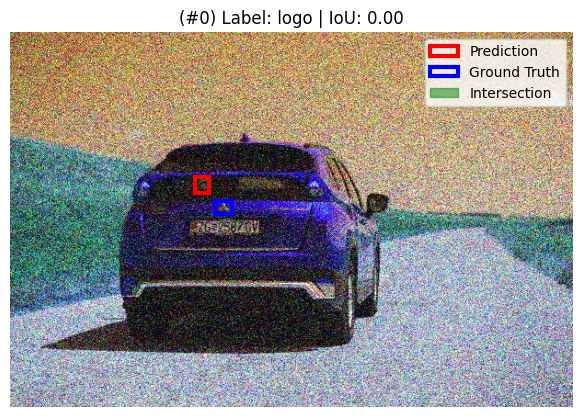


Average IoU: 0.0


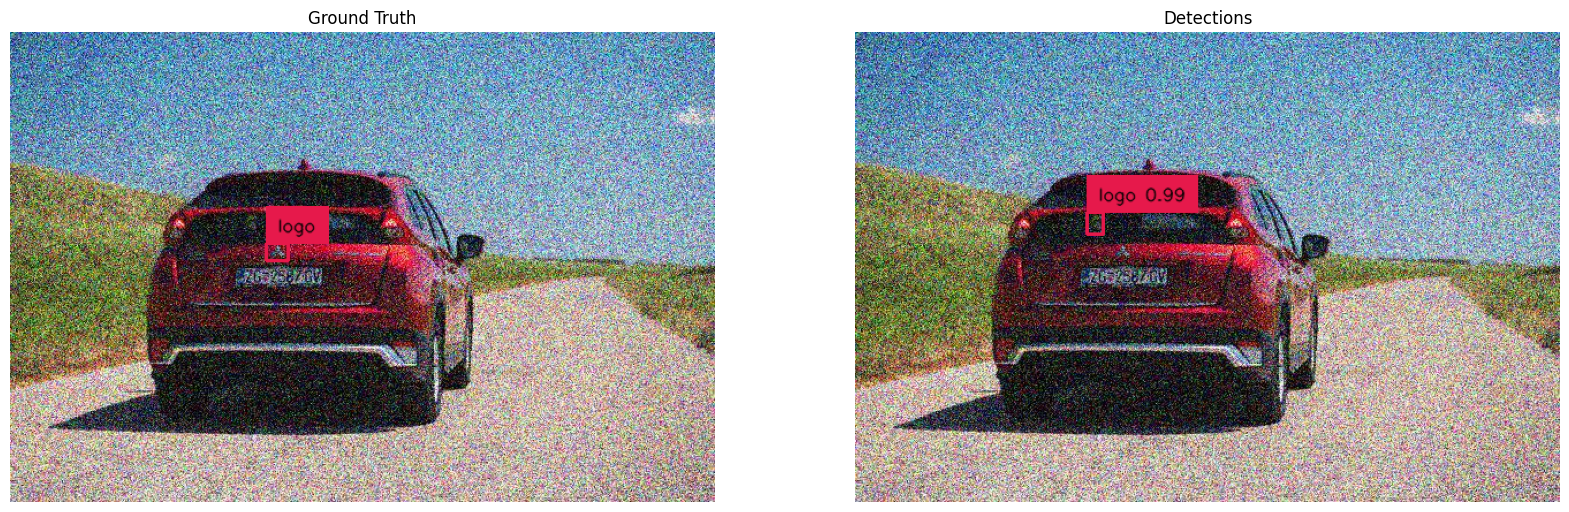

In [150]:
def get_intersection(box1, box2):
    """
    Computes the intersection between two bounding boxes.

    Args:
        box1 (list): [x1, y1, x2, y2] coordinates of the first bounding box.
        box2 (list): [x1, y1, x2, y2] coordinates of the second bounding box.

    Returns:
        tuple: intersection area coordinates [x1, y1, x2, y2].
        float: intersection area.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    return (x1, y1, x2, y2), intersection

def compute_iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (list): [x1, y1, x2, y2] coordinates of the first bounding box.
        box2 (list): [x1, y1, x2, y2] coordinates of the second bounding box.

    Returns:
        float: The IoU value.
    """
    _, intersection_area = get_intersection(box1, box2)
    
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area

    return iou

import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the functions get_intersection and compute_iou here

# Assuming you already have these imports
# from your previous code snippet
# VAL_DATASET, sv, os, model, image_processor, torch

# utils
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = VAL_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotations
image = VAL_DATASET.coco.loadImgs(image_id)[0]
annotations = VAL_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(VAL_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Annotate detections
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.5, 
        target_sizes=target_sizes
    )[0]

    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    total_iou = 0
    for idx, bbox in enumerate(results['boxes'].tolist()):
        print(f'Prediction #{idx}: {id2label[results["labels"][idx].item()]} | Confidence: {results["scores"][idx]:.3f}')
        plt.figure(figsize=(9,9))
        num_rows = (len(annotations) + 1) // 2
        
        max_iou = 0
        for ann_idx, gt in enumerate(annotations):
            gt_bbox = gt['bbox'].copy()
            gt_bbox[2] = gt_bbox[0] + gt_bbox[2]
            gt_bbox[3] = gt_bbox[1] + gt_bbox[3]

            iou = compute_iou(bbox, gt_bbox)
            if iou > max_iou and results['labels'][idx] == gt['category_id']:
                max_iou = iou

            plt.subplot(num_rows, 2, ann_idx + 1)
            plt.title(f'(#{ann_idx}) Label: {id2label[gt["category_id"]]} | IoU: {iou:.2f}')
            plt.imshow(image)
            ax = plt.gca()
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, color='r', linewidth=3, label='Prediction'))
            ax.add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2] - gt_bbox[0], gt_bbox[3] - gt_bbox[1], fill=False, color='b', linewidth=3, label='Ground Truth'))
            intersection = get_intersection(bbox, gt_bbox)[0]
            ax.add_patch(plt.Rectangle((intersection[0], intersection[1]), max(0, intersection[2] - intersection[0]), max(0, intersection[3] - intersection[1]),
                                    fill=True, color='g', linewidth=1, alpha=0.5, label='Intersection'))
            plt.axis('off')
            plt.legend()

            plt.subplots_adjust(right=1.5)

        plt.show()

        total_iou += max_iou

    print()
    print("Average IoU:", total_iou / len(results['boxes']))

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()

Image #1053
Prediction #0: logo | Confidence: 0.842


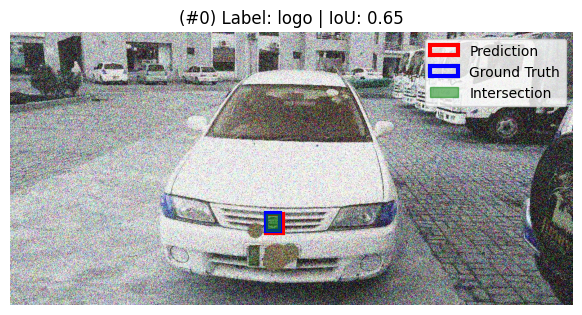

Prediction #1: logo | Confidence: 0.962


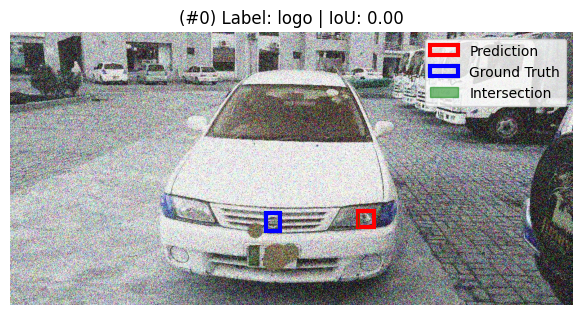


Average IoU: 0.32368738327048535


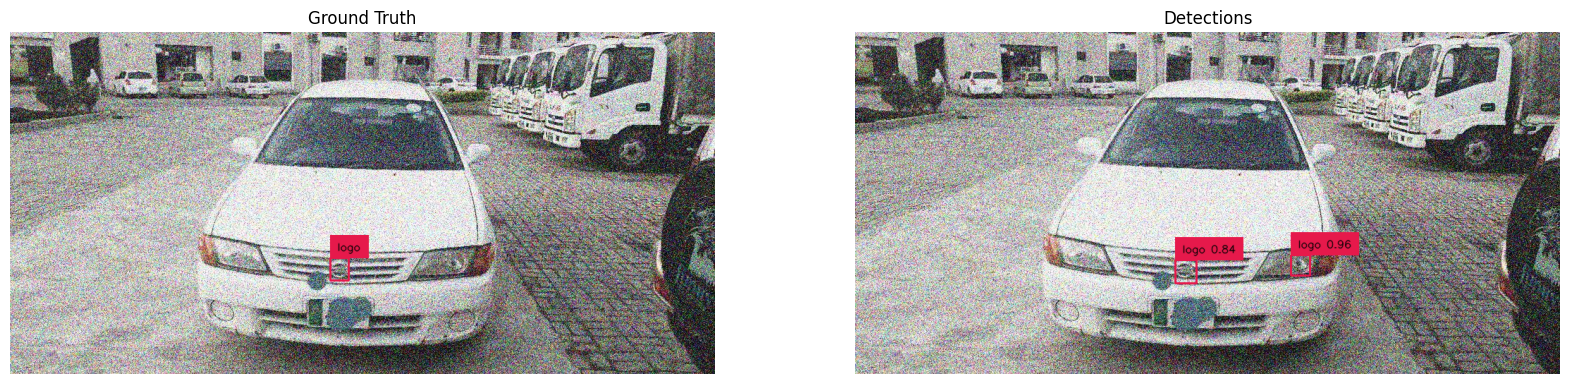

In [158]:
def get_intersection(box1, box2):
    """
    Computes the intersection between two bounding boxes.

    Args:
        box1 (list): [x1, y1, x2, y2] coordinates of the first bounding box.
        box2 (list): [x1, y1, x2, y2] coordinates of the second bounding box.

    Returns:
        tuple: intersection area coordinates [x1, y1, x2, y2].
        float: intersection area.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection = max(0, x2 - x1) * max(0, y2 - y1)

    return (x1, y1, x2, y2), intersection

def compute_iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) between two bounding boxes.

    Args:
        box1 (list): [x1, y1, x2, y2] coordinates of the first bounding box.
        box2 (list): [x1, y1, x2, y2] coordinates of the second bounding box.

    Returns:
        float: The IoU value.
    """
    _, intersection_area = get_intersection(box1, box2)
    
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)

    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area

    return iou

import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Define the functions get_intersection and compute_iou here

# Assuming you already have these imports
# from your previous code snippet
# VAL_DATASET, sv, os, model, image_processor, torch

# utils
categories = VAL_DATASET.coco.cats
id2label = {k: v['name'] for k,v in categories.items()}
box_annotator = sv.BoxAnnotator()

# select random image
image_ids = VAL_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotations
image = VAL_DATASET.coco.loadImgs(image_id)[0]
annotations = VAL_DATASET.coco.imgToAnns[image_id]
image_path = os.path.join(VAL_DATASET.root, image['file_name'])
image = cv2.imread(image_path)

# Annotate ground truth
detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

# Annotate detections
with torch.no_grad():

    # load image and predict
    inputs = image_processor(images=image, return_tensors='pt').to(device)
    outputs = model(**inputs)

    # post-process
    target_sizes = torch.tensor([image.shape[:2]]).to(device)
    results = image_processor.post_process_object_detection(
        outputs=outputs, 
        threshold=0.5, 
        target_sizes=target_sizes
    )[0]

    detections = sv.Detections.from_transformers(transformers_results=results)
    labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
    frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    total_iou = 0
    for idx, bbox in enumerate(results['boxes'].tolist()):
        print(f'Prediction #{idx}: {id2label[results["labels"][idx].item()]} | Confidence: {results["scores"][idx]:.3f}')
        plt.figure(figsize=(9,9))
        num_rows = (len(annotations) + 1) // 2
        
        max_iou = 0
        for ann_idx, gt in enumerate(annotations):
            gt_bbox = gt['bbox'].copy()
            gt_bbox[2] = gt_bbox[0] + gt_bbox[2]
            gt_bbox[3] = gt_bbox[1] + gt_bbox[3]

            iou = compute_iou(bbox, gt_bbox)
            if iou > max_iou and results['labels'][idx] == gt['category_id']:
                max_iou = iou

            plt.subplot(num_rows, 2, ann_idx + 1)
            plt.title(f'(#{ann_idx}) Label: {id2label[gt["category_id"]]} | IoU: {iou:.2f}')
            plt.imshow(image)
            ax = plt.gca()
            ax.add_patch(plt.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], fill=False, color='r', linewidth=3, label='Prediction'))
            ax.add_patch(plt.Rectangle((gt_bbox[0], gt_bbox[1]), gt_bbox[2] - gt_bbox[0], gt_bbox[3] - gt_bbox[1], fill=False, color='b', linewidth=3, label='Ground Truth'))
            intersection = get_intersection(bbox, gt_bbox)[0]
            ax.add_patch(plt.Rectangle((intersection[0], intersection[1]), max(0, intersection[2] - intersection[0]), max(0, intersection[3] - intersection[1]),
                                    fill=True, color='g', linewidth=1, alpha=0.5, label='Intersection'))
            plt.axis('off')
            plt.legend()

            plt.subplots_adjust(right=1.5)

        plt.show()

        total_iou += max_iou

    print()
    print("Average IoU:", total_iou / len(results['boxes']))

# Combine both images side by side and display
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(cv2.cvtColor(frame_ground_truth, cv2.COLOR_BGR2RGB))
axs[0].axis('off')
axs[0].set_title('Ground Truth')

axs[1].imshow(cv2.cvtColor(frame_detections, cv2.COLOR_BGR2RGB))
axs[1].axis('off')
axs[1].set_title('Detections')

plt.show()

In [23]:
from tqdm import tqdm

# Tahap ini menghitung IoU pada dataset

total_iou = 0
cnt = 0

for sample_idx in tqdm(range(len(VAL_DATASET))):
    # Load image and annotations
    image_id = VAL_DATASET.coco.getImgIds()[sample_idx]
    image_info = VAL_DATASET.coco.loadImgs(image_id)[0]
    image_path = os.path.join(VAL_DATASET.root, image_info['file_name'])
    image = cv2.imread(image_path)
    annotations = VAL_DATASET.coco.imgToAnns[image_id]

    detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
    labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
    frame_ground_truth = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

    with torch.no_grad():
        # load image and predict
        inputs = image_processor(images=image, return_tensors='pt').to(device)
        outputs = model(**inputs)

        target_sizes = torch.tensor([image.shape[:2]]).to(device)
        results = image_processor.post_process_object_detection(
            outputs=outputs, 
            threshold=0.5, 
            target_sizes=target_sizes
        )[0]

        detections = sv.Detections.from_transformers(transformers_results=results)
        labels = [f"{id2label[class_id]} {confidence:.2f}" for _, confidence, class_id, _ in detections]
        frame_detections = box_annotator.annotate(scene=image.copy(), detections=detections, labels=labels)

        total_iou_image = 0
        for idx, bbox in enumerate(results['boxes'].tolist()):
            max_iou = 0
            for gt in annotations:
                gt_bbox = gt['bbox'].copy()
                gt_bbox[2] = gt_bbox[0] + gt_bbox[2]
                gt_bbox[3] = gt_bbox[1] + gt_bbox[3]
                iou = compute_iou(bbox, gt_bbox)
                if iou > max_iou and results['labels'][idx] == gt['category_id']:
                    max_iou = iou
            total_iou_image += max_iou

        if len(results['boxes']) != 0:
            total_iou += (total_iou_image / len(results['boxes']))
            cnt += 1

# Calculate average IoU across all images
if cnt != 0:
    average_iou = total_iou / cnt
    print("Average IoU:", average_iou)
else:
    print("No bounding boxes detected in the validation dataset.")


100%|██████████| 1500/1500 [05:16<00:00,  4.74it/s]

Average IoU: 0.6707757343457497


# Evaluate the model

In [6]:
def convert_to_xywh(boxes):
    xmin, ymin, xmax, ymax = boxes.unbind(1)
    return torch.stack((xmin, ymin, xmax - xmin, ymax - ymin), dim=1)

def prepare_for_coco_detection(predictions):
    coco_results = []
    for original_id, prediction in predictions.items():
        if len(prediction) == 0:
            continue

        boxes = prediction["boxes"]
        boxes = convert_to_xywh(boxes).tolist()
        scores = prediction["scores"].tolist()
        labels = prediction["labels"].tolist()

        coco_results.extend(
            [
                {
                    "image_id": original_id,
                    "category_id": labels[k],
                    "bbox": box,
                    "score": scores[k],
                }
                for k, box in enumerate(boxes)
            ]
        )
    return coco_results

In [7]:
from coco_eval import CocoEvaluator
from tqdm.notebook import tqdm

import numpy as np

evaluator = CocoEvaluator(coco_gt=VAL_DATASET.coco, iou_types=["bbox"])

print("Running evaluation...")

for idx, batch in enumerate(tqdm(VAL_DATALOADER)):
    pixel_values = batch["pixel_values"].to(device)
    pixel_mask = batch["pixel_mask"].to(device)
    labels = [{k: v.to(device) for k, v in t.items()} for t in batch["labels"]]

    with torch.no_grad():
      outputs = model(pixel_values=pixel_values, pixel_mask=pixel_mask)

    orig_target_sizes = torch.stack([target["orig_size"] for target in labels], dim=0)
    results = image_processor.post_process_object_detection(outputs, target_sizes=orig_target_sizes)

    predictions = {target['image_id'].item(): output for target, output in zip(labels, results)}
    predictions = prepare_for_coco_detection(predictions)
    evaluator.update(predictions)

evaluator.synchronize_between_processes()
evaluator.accumulate()
evaluator.summarize()

Running evaluation...


  0%|          | 0/375 [00:00<?, ?it/s]

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


Accumulating evaluation results...
DONE (t=0.10s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=  3 ] = 0.508
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=  3 ] = 0.955
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=  3 ] = 0.481
 Average Precision  (AP) @[ IoU=0.95      | area=   all | maxDets=  3 ] = 0.001
 Average Precision  (AP) @[ IoU=0.50      | area= small | maxDets=  3 ] = 0.911
 Average Precision  (AP) @[ IoU=0.75      | area= small | maxDets=  3 ] = 0.299
 Average Precision  (AP) @[ IoU=0.95      | area= small | maxDets=  3 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  3 ] = 0.572
 Average Recall     (AR) @[ IoU=0.50      | area=   all | maxDets=  3 ] = 0.961
 Average Recall     (AR) @[ IoU=0.75      | area=   all | maxDets=  3 ] = 0.611
 Average Recall     (AR) @[ IoU=0.95      | area=   all | maxDets=  3 ] = 0.005
 Average Recall     (AR) @[ IoU=0.50      | area= sm